# import 

In [42]:
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import json, html, re
import numpy as np
from tqdm import tqdm
from glob import glob
from collections import Counter
from gensim.models import LdaModel
from gensim.corpora.dictionary import Dictionary
from gensim.test.utils import datapath
from datetime import timedelta, datetime
from pythainlp import word_tokenize
from pythainlp.corpus import thai_stopwords
STOPWORDS = thai_stopwords()

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
plt.style.use('ggplot')
font_path = '/Users/Nozomi/Library/Fonts/THSarabunNew.ttf'
font_label = fm.FontProperties(fname=font_path,weight='bold',size=25)

def clean(text, hashtag=None):
    if hashtag:
        text = text.replace(hashtag, '')
    text = html.unescape(text)
    text = re.sub(r'http.+?(?:\\s|$)', '', text) # URL link
    text = re.sub(r'[“”„]', '"', text) # convert double quotations into "
    text = re.sub(r'[‘’′′′′`]', "'", text) # convert single quotations into '
    text = re.sub(r'[ \u00a0\xa0\u3000\u2002-\u200a\t\n#]+', ' ', text) # shrink whitespaces e.g. good  boy -> good boy
    text = re.sub(r'[\r\u200b\ufeff]+', '', text) # remove non-breaking space
    text = re.sub(r'ํา','ำ', text) # am
    return text.strip()

def tokenize(text, hashtag=None):
    tokens = word_tokenize(clean(text, hashtag), keep_whitespace='False')
    tokens = [token for token in tokens if token not in STOPWORDS and re.match(r'[ก-๙][ก-๙\\.\\-]+$', token)]
    return tokens

def get_hour(row, string=True):
    date = datetime(row.date.year, row.date.month, row.date.day, int(row.time[:2]))
    if string:
        return str(date)[:-3] # '2021-04-09 22:00'
    else:
        return date # datetime.datetime(2021, 4, 9, 22, 0)

    
def timerange(df):
    oldest = get_hour(df.iloc[len(df)-1], False)
    latest = get_hour(df.iloc[0], False)
    range_list = [str(oldest)]
    while range_list[-1] != str(latest):
        oldest = oldest + timedelta(hours=1)
        range_list.append(str(oldest))
    return pd.DataFrame(range_list, columns=['date'])

def timerange_day(df):
    oldest = df.iloc[len(df)-1].date
    latest = df.iloc[0].date
    range_list = [str(oldest).split()[0]]
    while range_list[-1] != str(latest).split()[0]:
        oldest = oldest + timedelta(days=1)
        range_list.append(str(oldest).split()[0])
    return pd.DataFrame(range_list, columns=['date'])

In [60]:
!ls tweets

#16ตุลาไปแยกปทุมวัน.csv
#16ตุลาไปแยกปทุมวัน.json
#25พฤศจิกาไปSCB.csv
#25พฤศจิกาไปSCB.json
#saveวันเฉลิม.csv
#saveวันเฉลิม.json
#ม็อบ25พฤศจิกาทวงคืนสมบัติชาติ.csv
#ม็อบ25พฤศจิกาทวงคืนสมบัติชาติ.json
#ม็อบ2ธันวา.csv
#ม็อบ2ธันวา.json
#ธรรมศาสตร์และการชุมนุม.csv
#ธรรมศาสตร์และการชุมนุม.json
#กูสั่งให้มึงอยู่ใต้รัฐธรรมนูญ.csv
#เกียมอุดมไม่ก้มหัวให้เผด็จการ.csv
#กูสั่งให้มึงอยู่ใต้รัฐธรรมนูญ.json
#เกียมอุดมไม่ก้มหัวให้เผด็จการ.json
badstudent_tweet.csv
badstudent_tweet.json
badstudent_tweet_raw.csv
freeyouth_tweet.csv
freeyouth_tweet.json
freeyouth_tweet_raw.csv
tanawatofficial_tweet.csv
tanawatofficial_tweet.json
tanawatofficial_tweet_raw.csv
thammasatUFTD_tweet.csv
thammasatUFTD_tweet.json
thammasatUFTD_tweet_raw.csv
ประเทศกูมี.csv
ประเทศกูมี.json
ประเทศกูมี_tokenized.json
ถ้าการเมืองดี.csv
ถ้าการเมืองดี.json
ถ้าการเมืองดี_tokenized.json
ให้มันจบที่รุ่นเรา.json


In [74]:
filename = 'tweets/ประเทศกูมี.json'
filename = 'tweets/ถ้าการเมืองดี.json'
#filename = 'tweets/ให้มันจบที่รุ่นเรา.json'
num = 20

# tokenize

In [62]:
df = pd.read_json(filename, lines=True).drop_duplicates('id')
df = df.reset_index(drop=True)

### define duration ###
df = df[(df.date >= '2020-1-1') & (df.date <= '2020-12-31')]

### tokenize ###
df['tokens'] = df.tweet.apply(lambda x: tokenize(x))
df

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,tokens
5,1344672321089376257,1344672321089376256,2020-12-31 22:50:38+07:00,2020-12-31,22:50:38,700,843463538999869441,ty1412__,ไข่หวาน ||| ft.🤍🐸🐯👼🏻* ꒱,,...,,,,,[],,,,,"[ไข่หวาน, ขอพร, คน, ที่ผ่านมา, มีความสุข, ทำ, ..."
6,1344636989039992841,1344636989039992832,2020-12-31 20:30:14+07:00,2020-12-31,20:30:14,700,406718836,bussbussaya,บา บา บาน่านา,,...,,,,,[],,,,,"[สรุป, ปี, หัวหน้า, โอเค, เพื่อนร่วมงาน, โอเค,..."
7,1344636168877457409,1344636168877457408,2020-12-31 20:26:59+07:00,2020-12-31,20:26:59,700,1262927366281588736,bts2523,Save0909,,...,,,,,[],,,,,"[วันสุดท้าย, ปี, ออกจาก, ชีวิต, เข้ามา, กี่, จ..."
8,1344630455862116352,1344558551281225728,2020-12-31 20:04:17+07:00,2020-12-31,20:04:17,700,1302837205837127682,som60783057,som,,...,,,,,"[{'screen_name': 'AmaratJeab', 'name': 'อมรัตน...",,,,,"[รู้จัก, แยกแยะ, ทำตาม, สั่ง, คน, เครื่องแบบ, ..."
9,1344619826619158528,1344609381405507584,2020-12-31 19:22:03+07:00,2020-12-31,19:22:03,700,60007980,me_meiyo,have a sunny day 𓃠 ft. thesis from hell,,...,,,,,[],,,,,"[ปี, การตื่น, ตื่น, หลับ, ยินดี, ตื่น, ยินดี, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12570,1214113790746169345,1214113776045187072,2020-01-06 16:17:39+07:00,2020-01-06,16:17:39,700,3324242334,kr_kurenai,||| 🌘クレナイ🌒🏳️‍🌈☆𝑻𝒂𝒉— CommissionทักDmเลยครับ,,...,,,,,[],,,,,"[น่ารังเกียจ, จบ, ตอน, ม., ต้น, โดน, คุกคาม, แ..."
12571,1213678527020580864,1213625221606805504,2020-01-05 11:28:04+07:00,2020-01-05,11:28:04,700,1974765654,moo_satoung,⚡🐥💜💐💙🐿️🌪️ #LALISA,,...,,,,,"[{'screen_name': 'Pacman0072', 'name': 'Jira P...",,,,,"[รณรงค์, ปลูกฝัง, เลิก, พฤติกรรม, แบบนี้, ป่ะ,..."
12572,1213072423215460352,1213072423215460352,2020-01-03 19:19:38+07:00,2020-01-03,19:19:38,700,41079723,nannnabelle,✨ลูกโหน่งแร๊พไฟแล่บ🌟 🎡,,...,,,,,[],,,,,"[คน, เล่น, คสอ, ฟัง, เพลิน, ชอบ, มุ่งมั่น, หา,..."
12573,1212860644510203904,1212857680789823488,2020-01-03 05:18:06+07:00,2020-01-03,05:18:06,700,390697392,chiradech,God Ji,,...,,,,,[],,,,,"[โมเมนต์, เด็ก, หงส์, รุ่น, จดจำ, ได้ดี, สวนทา..."


In [63]:
df.to_json(filename.replace('.json','_tokenized.json'), orient='records')

# frequent hashtag & cooccurent words

In [75]:
df = pd.read_json(filename.replace('.json','_tokenized.json'))


##### hashtags #####
hashtag_counter = Counter()
for lst in tqdm(df.hashtags):
    hashtag_counter.update(lst)
    
hashtag2word = {x[0]:Counter() for x in hashtag_counter.most_common(num)}

# count frequent words
for i, row in tqdm(df.iterrows()):
    for hashtag in row['hashtags']:
        if hashtag in hashtag2word:
            hashtag2word[hashtag].update(row['tokens'])
    
print("|hashtag|count|frequent words|oldest|popular|\n|:-:|:-:|:-:|:-:|:-:|")
for tag, c, in hashtag_counter.most_common(num):
    tempdf = df[df.hashtags.apply(lambda x: tag in x)].sort_values(['created_at'])
    
    ## frequent words
    freqs = " ".join([f"{w}({c})" for w,c in hashtag2word[tag].most_common(10)])
    
    ## oldest
    oldest = tempdf.iloc[0].tweet
    oldest_name = tempdf.iloc[0].username
    oldest_link = tempdf.iloc[0].link
    oldest_date = str(tempdf.iloc[0]['created_at']).split('+')[0]
    
    ## popular
    tempdf = tempdf.sort_values(["retweets_count"], ascending=False)
    popular = tempdf.iloc[0].tweet
    popular_name = tempdf.iloc[0].username
    popular_link = tempdf.iloc[0].link
    popular_date = str(tempdf.iloc[0]['created_at']).split('+')[0]
    retweet_count = tempdf.iloc[0].retweets_count
    
    print(f"|{tag}|{c}|{freqs}|[{oldest_date}]({oldest_link})<br>[@{oldest_name}](https://twitter.com/{oldest_name})<br><br>{oldest.replace('|||','')}|[{popular_date}]({popular_link})<br>[@{popular_name}](https://twitter.com/{popular_name})<br>{retweet_count} retweets<br><br>{popular.replace('|||','')}|")

100%|██████████| 118987/118987 [00:00<00:00, 234865.31it/s]
118987it [00:21, 5575.98it/s]


|hashtag|count|frequent words|oldest|popular|
|:-:|:-:|:-:|:-:|:-:|
|ถ้าการเมืองดี|46308|ดี(56021) การเมือง(50218) คน(8502) ไม่ต้อง(7332) ประเทศ(5012) ม็อบ(4959) ทำ(4346) ประชาชน(3967) ไทย(3704) แบบนี้(3566)|[2020-07-19 06:20:49](https://twitter.com/InfinitaSub/status/1284734923811590144)<br>[@infinitasub](https://twitter.com/infinitasub)<br><br>เรามาเล่นแทกอะไรกันไหมคะ?   #ถ้าการเมืองดี เราจะมีเงินเดือนที่สูงขึ้น บัตรคอน 5-6-7 พันเหรอ เหอะ! สบายจ้าาาาาาาาาาา|[2020-08-14 02:43:30](https://twitter.com/paolonapaul/status/1294102319664001024)<br>[@paolonapaul](https://twitter.com/paolonapaul)<br>89671 retweets<br><br>ต่อให้รถติด แต่รถสาธารณะต้องไม่ติด  . #เกาหลี #ถ้าการเมืองดี #ขนส่งจะดี #คนเดินเท้า  https://t.co/SrVuemU1Kc|
|เยาวชนปลดเเอก|2091|ดี(2258) การเมือง(2221) เยาวชน(2129) ปลด(2104) เอก(2100) จบ(824) รุ่น(793) คน(397) พร(355) สู้(303)|[2020-07-18 19:58:48](https://twitter.com/pppsubmarine/status/1284578387952955392)<br>[@pppsubmarine](https://twitter.com/pppsubmarine)<br><br>คิดดู

In [80]:
df = df.reset_index(drop=True)
df

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,tokens
0,1344688919741304842,1344688919741304832,2020-12-31 16:56:36,2020-12-31,23:56:36,700,1129794878999687168,somethingting,ซัมติงติ่ง,,...,,,,,[],,,,,"[ข้าม, ปี, ปี, การเมือง, ดี]"
1,1344682044387852288,1344682044387852288,2020-12-31 16:29:17,2020-12-31,23:29:17,700,1341188259506843649,ypkhsyy,คุรกก #TPST,,...,,,,,[],,,,,"[ประเทศ, ไลฟ์, โค้ช, แม่, การเมือง, ดี, ระบบ, ..."
2,1344678348501336065,1344674763357081600,2020-12-31 16:14:35,2020-12-31,23:14:35,700,1213886622283919363,judythecatz,J. Pledleton |,,...,,,,,"[{'screen_name': 'MyLitChildhood', 'name': 'Bi...",,,,,"[สาทุ, ที่สอง, การเมือง, ดี, เดี๋ยว, ผัว]"
3,1344677122766356480,1344677122766356480,2020-12-31 16:09:43,2020-12-31,23:09:43,700,145568489,honeybzzz29,honeybzzz,,...,,,,,[],,,,,"[การเมือง, ดี]"
4,1344675201896775680,1344675201896775680,2020-12-31 16:02:05,2020-12-31,23:02:05,700,755292232039542784,yufenggg,🔥ลักยิ้มบนแก้มเจ้าจวิ้น,,...,,,,,[],,,,,"[การเมือง, ดี, ต้ิง, แหก, หี, ไผ, บริจาค, ดอย]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118982,1212735218617995266,1211557321597313024,2020-01-02 13:59:42,2020-01-02,20:59:42,700,948972629636956161,star75225960,ทิ้งไวกลางทาง,,...,,,,,"[{'screen_name': 'johnwinyu', 'name': 'John Wi...",,,,,"[หมา, ดีกว่า, ตา, ลุง, คน, ลุง, เล่นการเมือง, ..."
118983,1212446213993160704,1212446213993160704,2020-01-01 18:51:18,2020-01-02,01:51:18,700,775321083943591936,khingpitcha,Minny,,...,,,,,[],,,,,"[เกาหลี, สุดยอด, แม่, รู้, ดู, ตะลึง, พระเอก, ..."
118984,1212412674958487552,1212412674958487552,2020-01-01 16:38:01,2020-01-01,23:38:01,700,3265736412,dearmissjanedoe,Jane Doe lll,,...,,,,,[],,,,,"[มุมมอง, เรื่องราว, ได้ดี, เรื่อง, สามัญ, เรื่..."
118985,1212351077653176320,1212351077653176320,2020-01-01 12:33:15,2020-01-01,19:33:15,700,2351874080,swifties378,"19 พฤศจิ—Red(Taylor’s ver.) .|||, ☔︎︎",,...,,,,,[],,,,,"[บ้าน, ดู, เนชั่น, แล้วก็, เมือง, ไทย, อะ, เจร..."


In [66]:
column = ['date','time','username','tweet','hashtags','link','quote_url','urls','photos','thumbnail','mentions','reply_to','replies_count','retweets_count','likes_count']

df[column].to_csv(filename.replace('.json','.csv'), index=False)

# hashtag timeseries

100%|██████████| 10/10 [00:20<00:00,  2.02s/it]


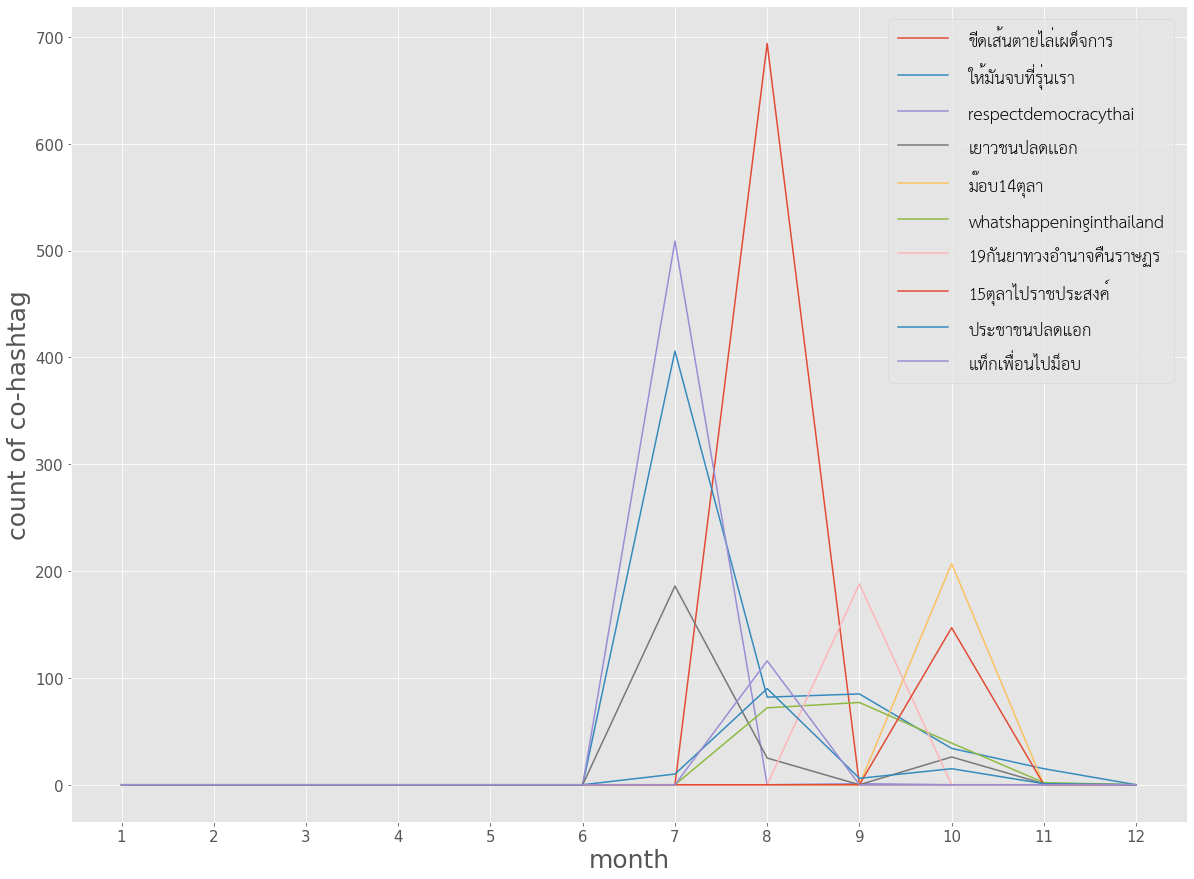

In [67]:
### plot time series ###

start_m = 1
xs = list(range(start_m, 13))

fig = plt.figure(figsize=(20,15))

for tag, count in tqdm(hashtag_counter.most_common(11)[1:]): # exclude original hashtag
    counts = []  
    for m in range(start_m, 13):
        count = 0
        thismonth_df = df[df.date.dt.month == m]
        for i, row in thismonth_df.iterrows():
            if tag in row['hashtags']:
                count += 1
        counts.append(count)

    plt.plot(xs, counts, label=tag)

plt.xticks(xs, size=15)
plt.yticks(size=15)
plt.legend(prop=font_label)
plt.xlabel('month', size=25)
plt.ylabel('count of co-hashtag', size=25)
plt.show()

# LDA

In [68]:
%%time

##### TRAIN #####

num_topic = 5

corpus_dictionary = Dictionary(df.tokens)
corpus = []
for tokens_list in tqdm(df.tokens):
    corpus.append(corpus_dictionary.doc2bow(tokens_list))
lda = LdaModel(corpus, num_topics=num_topic, id2word=corpus_dictionary, passes=10)

100%|██████████| 12570/12570 [00:00<00:00, 46660.96it/s]


CPU times: user 1min 3s, sys: 1.04 s, total: 1min 4s
Wall time: 1min 5s


In [77]:
# Save  & Load

temp_file = datapath(filename.replace('tweets/','').replace('.json',''))
#lda.save(temp_file)
lda = LdaModel.load(temp_file)

In [78]:
### print result of keywords ###
print('|rank|topic 1||topic 2||topic 3||topic 4||topic 5||\n|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|')
for i in range(10):
    print(f'|{i+1}', end='')
    for j in range(5):
        word, score = lda.show_topic(j)[i]
        print(f"|{word}|{score:.3f}",end="")
    print('|')

|rank|topic 1||topic 2||topic 3||topic 4||topic 5||
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|1|การเมือง|0.058|ดี|0.064|ดี|0.138|การเมือง|0.059|เยาวชน|0.065|
|2|ดี|0.051|การเมือง|0.060|การเมือง|0.119|ดี|0.057|จบ|0.044|
|3|คน|0.019|กุ|0.025|ไม่ต้อง|0.049|คน|0.024|รุ่น|0.034|
|4|ประเทศ|0.017|อี|0.020|ซื้อ|0.019|เรื่อง|0.022|ดี|0.030|
|5|ประชาชน|0.017|เหี้ย|0.017|รอ|0.018|ทำ|0.015|การเมือง|0.029|
|6|เอก|0.014|เดิน|0.015|นั่ง|0.016|ดีกว่า|0.012|โรงเรียน|0.015|
|7|ปลด|0.013|ขนส่ง|0.011|รถเมล์|0.015|ดีขึ้น|0.010|ครู|0.013|
|8|ไทย|0.012|สาธารณะ|0.011|รถ|0.015|เรียน|0.010|ปลดแอก|0.012|
|9|รัฐบาล|0.012|อิ|0.010|แบบนี้|0.012|อะ|0.009|น้ำ|0.010|
|10|โดน|0.008|บ้าน|0.009|เงิน|0.010|ตัวเอง|0.008|สภา|0.009|


In [79]:
### prediction - argmax ###

n = len(df)

result_matrix = np.zeros((n, num_topic))
for row, dist in enumerate(lda.get_document_topics(corpus[:n])):
    for tpl in dist:
        col = tpl[0]
        result_matrix[row,col] = tpl[1]
        
result_df = pd.DataFrame(result_matrix)
result_df['topic'] = result_df.apply(lambda row: np.argmax(row), axis=1)
result_df['tweet'] = df.tweet.reset_index(drop=True)
result_df['date'] = df.apply(lambda row: get_hour(row), axis=1).reset_index(drop=True)

result_df

,0,1,2,3,4,topic,tweet,date
0,0.000000,0.000000,0.372449,0.605782,0.000000,3,ก่อนจะข้ามปี 2020 ขอยก # แห่งปีให้กับ #ถ้าการเ...,2020-12-31 23:00
1,0.000000,0.196415,0.134087,0.502118,0.158428,3,ประเทศแห่งไลฟ์โค้ชมากจ้ะแม่ ถ้าการเมืองดีระบบบ...,2020-12-31 23:00
2,0.028601,0.351515,0.191069,0.254140,0.174675,1,@MyLitChildhood สาทุอันที่สองเถอะ ถ้าการเมืองด...,2020-12-31 23:00
3,0.179494,0.000000,0.162748,0.594912,0.054738,3,#whatshappeninginthailand #ถ้าการเมืองดี,2020-12-31 23:00
4,0.049012,0.000000,0.043504,0.858735,0.041599,3,ถ้าการเมืองดี เราจะไม่ต้ิงแหกหีไผบริจาคของบนดอย,2020-12-31 23:00
...,...,...,...,...,...,...,...,...
118982,0.000000,0.000000,0.000000,0.000000,0.000000,0,@johnwinyu เชื่อหมายังดีกว่าเชื่อตาลุงคนนี้ ลุ...,2020-01-02 20:00
118983,0.000000,0.000000,0.000000,0.000000,0.000000,0,เกาหลีสุดยอดจ้าแม่ เมื่อก่อนไม่รู้เคยมีมั้ยแต่...,2020-01-02 01:00
118984,0.000000,0.000000,0.000000,0.000000,0.000000,0,ถ้าอยากเข้าใจมุมมองและเรื่องราวต่างๆได้ดี ไม่ว...,2020-01-01 23:00
118985,0.000000,0.000000,0.000000,0.000000,0.000000,0,ที่บ้านดูเนชั่นแล้วก็บอก เมืองไทยอะไม่มีวันเจร...,2020-01-01 19:00


In [81]:
### print prediction ###

print('|tweet|topic|prob of 1|2|3|4|5|\n|:-:|:-:|:-:|:-:|:-:|:-:|:-:|')
for i, row in result_df[['tweet','topic',0,1,2,3,4]].sample(10).iterrows():
    print(f'|{row.tweet}|{row.topic+1}|{row[0]:.3f}|{row[1]:.3f}|{row[2]:.3f}|{row[3]:.3f}|{row[4]:.3f}|')

|tweet|topic|prob of 1|2|3|4|5|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|เดบิ้วมาเป็นแอคฉอดการเมืองก่อนเลย #ถ้าการเมืองดี nctจะจัดคอนที่จังหวัดอื่นนอกจากกทม.ได้|4|0.151|0.136|0.137|0.411|0.164|
|@KiMPiN9ss_ ใช่ตอนแรกปู่มาดี อยากเอาใจคนดูนางงาม+ตามการเมือง หว่านฐานคนดู พอเจอคำถามไฟนอลเข้าไป งื้ออออ ไม่มีเวทีไหนถามแล้ววว คำถามชาตินิยม ตอนวณตอบเสร็จพี่พนมมือเลย อย่าได้ ถ้าตอบแบบนี้บน เวที mu คือตุบแน่นอน|1|0.000|0.000|0.000|0.000|0.000|
|ถ้าการเมืองดี ปชชจะไม่ต้องโดเนทเงิน รัฐบาลจะแก้ปัญหาได้ทัน และเยียวยาได้รวดเร็ว! แต่ความจริง คือเอาเงินที่กู้มาไปแดกกันหมดแร้ววววววววว  https://t.co/zCoMbqnEBZ|1|0.000|0.000|0.000|0.000|0.000|
|#ถ้าการเมืองดี ต่อให้ยายจะถูกวินิจฉัยว่าตาพร่าเลือนเพราะอายุขัย และไม่เข้าข่ายคนพิการยายก็ยังมีสวัสดิการด้านอื่น และมีเบี้ยคนชราเลี้ยงตัวยายอยู่ดี ฉันถอนหายใจกับประเทศนี้ครั้งที่ร้อย รักมากนะ อยากให้ดีขึ้น แต่ทำไมนับวันมันยิ่ง hopeless country with hopeless people จังเลยอะ|5|0.111|0.000|0.268|0.294|0.319|
|ตอนเยนซื้อข้าวเกรียบปลามาสองถุงเพราะสงสารลุงคนขาย แบบเปนคนมีอายุแล้วเ

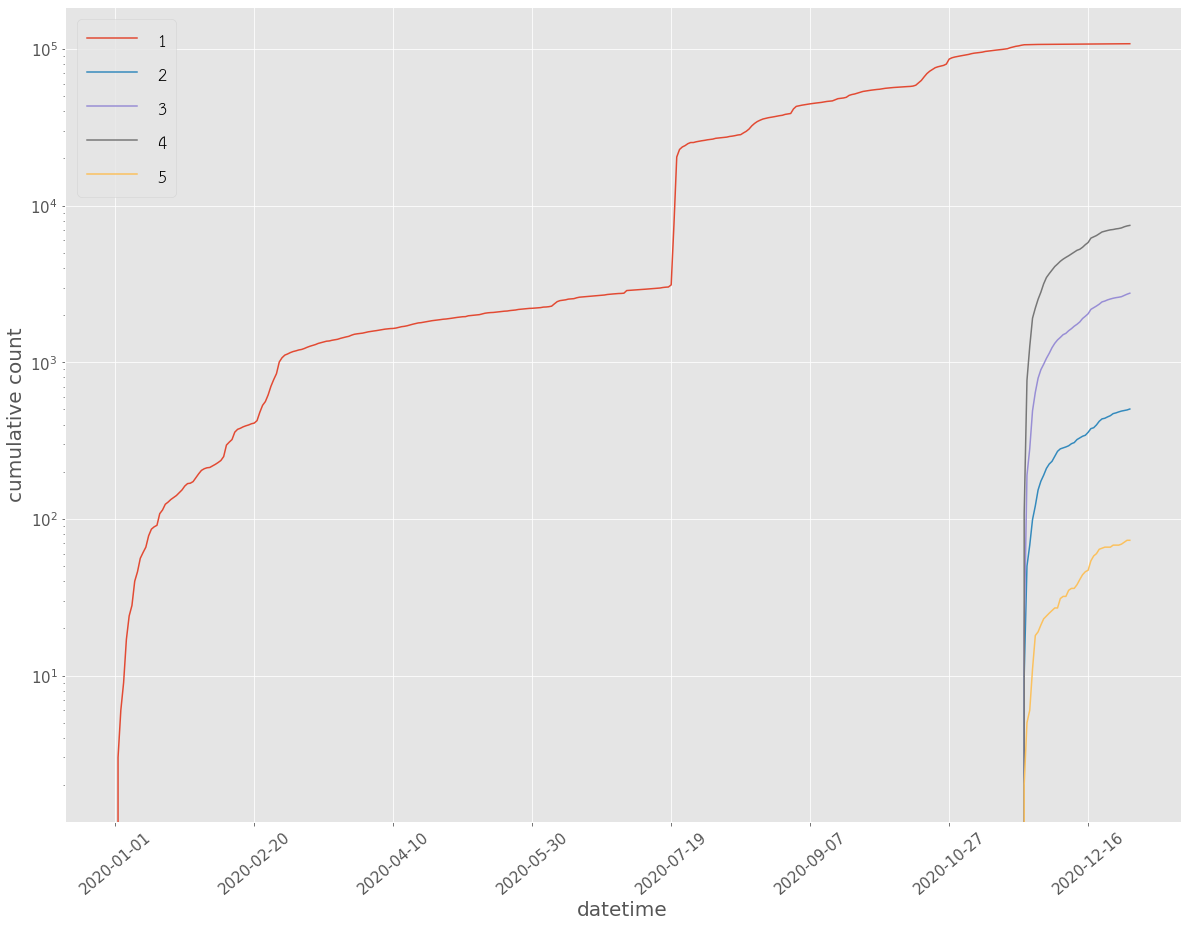

In [82]:
### plot topic time series ###

tempdf = timerange_day(df)

for t in range(5):
    tempdf[t+1] = tempdf.date.apply(lambda x: sum((result_df.date <= x) & (result_df.topic==t)))
    
tempdf.plot(x='date', figsize=(20,15))
plt.legend(prop=font_label)
plt.ylabel('cumulative count', size=20)
plt.xlabel('datetime', size=20)
plt.xticks(rotation=40, size=15)
plt.yticks(size=15)
plt.yscale('log')
plt.show()